In [39]:
from datetime import datetime
import json
import operator
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
import pickle

import jax
from jax import numpy as jnp
from jax.tree_util import tree_reduce, tree_map

import tensorflow as tf

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from tqdm import tqdm

from run_experiment import MLP, get_datasets, factorize

plt.rc('font', family='serif')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
def load_experiment_results(results_dir):

    results = []
    configs = []

    for exp_id in next(os.walk(results_dir))[1]:

        try:
            # load the experiment's config
            with open(os.path.join(results_dir, exp_id, "experiment.json"), "r") as file:
                exp = json.load(file)

            # load the training log
            with open(os.path.join(results_dir, exp_id, "out.log"), "r") as file:
                log = file.read()

            # load the metrics
            with open(os.path.join(results_dir, exp_id, "metrics.json"), "r") as file:
                metrics = json.load(file)

            # get epoch of best model
            best_model_fn = [fn for fn in next(os.walk(os.path.join(results_dir, exp_id)))[2] if fn.startswith("best_params")][0]
            best_epoch = int(best_model_fn.split("_")[-1].split(".")[0])

            exp["id"] = exp_id

            configs.append(exp)

            results.append({
                "id": exp_id,
                "n_train": exp["n_train"],
                "best_epoch": best_epoch,
                "train_loss": metrics["train_loss"][best_epoch - 1],
                "train_accuracy": metrics["train_accuracy"][best_epoch - 1],
                "test_loss": metrics["test_loss"][best_epoch - 1],
                "test_accuracy": metrics["test_accuracy"][best_epoch - 1],
            })
        
        except:
            print(f"Error loading experiment {exp_id}, skipping")
    
    return results, configs

results_by_exp = {}

for exp in next(os.walk(os.path.join("results", "run_experiment.py.d")))[1]:
    
    print(exp)
    results_by_exp[exp] = {}
    results_dir = os.path.join("results", "run_experiment.py.d", exp)
    results_by_exp[exp]["results"], results_by_exp[exp]["config"] = load_experiment_results(results_dir)
    results_by_exp[exp]["df"] = pd.DataFrame(results_by_exp[exp]["results"]).set_index("id").sort_values("n_train")


cifar10_full.json_2023-08-25_11-43-34.d
cifar10_factorized.json_2023-08-25_00-54-04.d
mnist_full.json_2023-08-25_00-54-04.d
test.json_2023-08-25_17-24-35.d
mnist_factorized_new.json_2023-08-25_15-36-12.d
mnist_factorized.json_2023-08-25_00-15-19.d
mnist_linear.json_2023-08-25_00-54-04.d
mnist_factorized.json_2023-08-25_11-43-34.d
cifar10_full.json_2023-08-24_23-09-33.d
cifar10_linear.json_2023-08-25_11-43-34.d
mnist_factorized.json_2023-08-25_00-54-04.d
cifar10_full.json_2023-08-25_00-54-04.d
mnist_linear.json_2023-08-25_11-43-34.d
mnist_full.json_2023-08-25_11-43-34.d
cifar10_factorized.json_2023-08-24_23-09-33.d
mnist_factorized_new.json_2023-08-25_15-17-04.d
cifar10_linear.json_2023-08-24_23-09-33.d
mnist_linear.json_2023-08-25_00-15-19.d
cifar10_linear.json_2023-08-25_00-54-04.d
mnist_full.json_2023-08-25_00-15-19.d
cifar10_factorized.json_2023-08-25_11-43-34.d
cifar10_factorized_new.json_2023-08-25_15-36-12.d
test.json_2023-08-25_15-14-39.d


In [3]:
model_types = [
    ("full", "Standard NN"),
    ("linear", "Tangent"),
    ("factorized", "Adaptive"),
]

prefixes = ["mnist", "cifar10"]
suffixes = [".json_2023-08-25_00-54-04.d", ".json_2023-08-25_11-43-34.d"]

grouped_stats = {}

for prefix in prefixes:
    for model_type, model_type_name in model_types:
        df = None
        for suffix in suffixes:
            idx = f"{prefix}_{model_type}{suffix}"
            if idx not in results_by_exp:
                continue
            if df is None:
                df = results_by_exp[idx]["df"]
            else:
                df = pd.concat([df, results_by_exp[idx]["df"]])
        df["test_error"] = 1 - df["test_accuracy"]
        grouped_stats[f"{prefix}_{model_type}"] = df.groupby("n_train").agg(["mean", "std"])


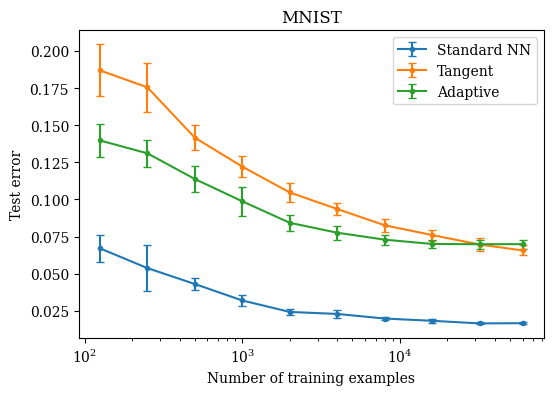

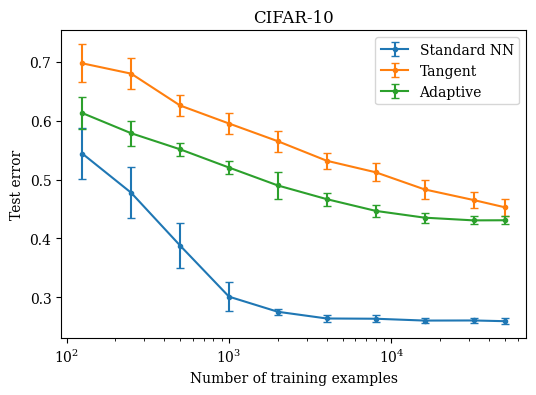

In [4]:
for prefix, title in [("mnist", "MNIST"), ("cifar10", "CIFAR-10")]:

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    for type, name in model_types:
        idx = f"{prefix}_{type}"
        grouped_stats[idx]["test_error"].plot(ax=ax, y="mean", yerr="std", label=name, capsize=3, marker="o", ms=3)

    plt.legend()
    plt.xlabel("Number of training examples")
    plt.ylabel("Test error")
    plt.xscale("log")
    plt.title(title)
    plt.show()

In [5]:
suffix = ".json_2023-08-25_00-54-04.d"

for exp, collection in results_by_exp.items():
    results = collection["results"]
    config = collection["config"]

    if not exp.endswith(suffix):
        continue

    for result, config in zip(results, config):
        if result["n_train"] == 500 and config["seed"] == 0:
            pkl_fn = os.path.join("results", "run_experiment.py.d", exp, result["id"], f"best_params_epoch_{result['best_epoch']}.pkl")
            init_fn = os.path.join("results", "run_experiment.py.d", exp, result["id"], f"initial_params.pkl")

            if exp.startswith("mnist_factorized"):
                print("Loading factorized params")
                print(exp)
                with open(pkl_fn, "rb") as file:
                    mnist_factorized_params = pickle.load(file)

            elif exp.startswith("mnist_linear"):
                print("Loading linear params")
                print(exp)
                with open(pkl_fn, "rb") as file:
                    mnist_linear_params = pickle.load(file)

            elif exp.startswith("mnist_full"):
                print("Loading full params")
                print(exp)
                exp_config = config
                with open(pkl_fn, "rb") as file:
                    mnist_full_params = pickle.load(file)
                with open(init_fn, "rb") as file:
                    mnist_full_init_params = pickle.load(file)

Loading full params
mnist_full.json_2023-08-25_00-54-04.d
Loading linear params
mnist_linear.json_2023-08-25_00-54-04.d
Loading factorized params
mnist_factorized.json_2023-08-25_00-54-04.d


Dense_0
Dense_1
Dense_2
Dense_3
Dense_4


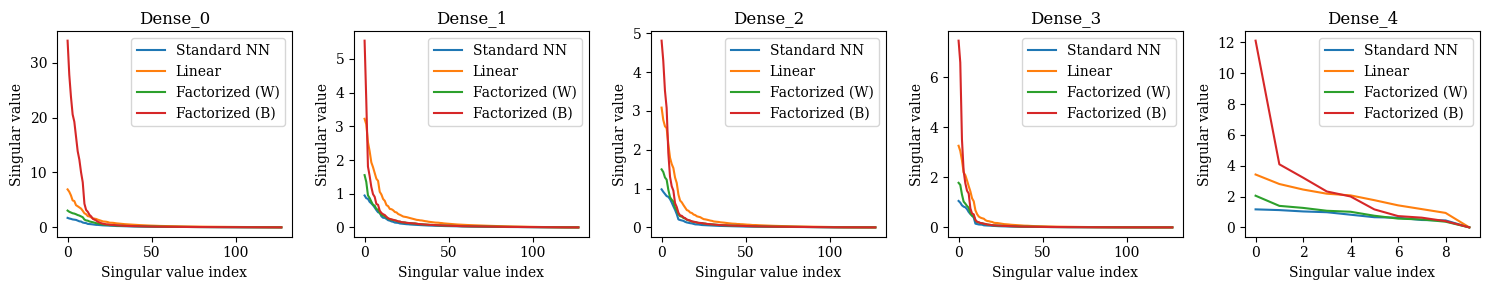

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for (k, factorized_v), ax in zip(mnist_factorized_params["delta"]["params"].items(), axes):
    print(k)

    full_v = mnist_full_params[k]
    full_init_v = mnist_full_init_params[k]
    Theta = full_v["kernel"] - full_init_v["kernel"]

    U, s, Vh = jnp.linalg.svd(Theta, full_matrices=False)
    ax.plot(s, label="Standard NN")

    linear_v = mnist_linear_params["delta"]["params"][k]
    Theta_lin = linear_v["kernel"]

    U, s, Vh = jnp.linalg.svd(Theta_lin, full_matrices=False)
    ax.plot(s, label="Linear")
    
    factorized_v = factorized_v["Dense_factorized"]
    M1 = factorized_v["M1"]
    W = factorized_v["kernel"]
    M2 = factorized_v["M2"]
    B = M1 @ W @ M2

    U, s, Vh = jnp.linalg.svd(W, full_matrices=False)
    ax.plot(s, label="Factorized (W)")

    U, s, Vh = jnp.linalg.svd(B, full_matrices=False)
    ax.plot(s, label="Factorized (B)")

    ax.set_title(k)
    ax.set_xlabel("Singular value index")
    ax.set_ylabel("Singular value")
    ax.legend()

plt.tight_layout()
plt.show()

In [41]:
tf.random.set_seed(0)
train_ds, test_ds = get_datasets("mnist", 1, 2000, 2000)
train_np = train_ds.as_numpy_iterator().next()
X_train, y_train = train_np["image"], train_np["label"]

In [42]:
mask_23 = jnp.logical_or(y_train == 2, y_train == 3)
X = X_train[mask_23, :]
y = y_train[mask_23]
idx = jnp.argsort(y)
X = X[idx, :]
y = y[idx]

Xsample = jnp.vstack([X[:100, :], X[-100:, :]])

model = MLP(depth=exp_config["depth"], width=exp_config["width"])

In [43]:
mno = "mnopqrstuvwxyz"
def inner_prod(a, b):
    dims = a.ndim - 2
    return jnp.einsum(f"ij{mno[:dims]},kl{mno[:dims]}->ijkl", a, b)

def remove_Ms(J):

    def remove_Ms_single(leaf):
        if "Dense_factorized" in leaf:
            factors = leaf["Dense_factorized"]
            del factors["M1"]
            del factors["M2"]
            return factors
        else:
            return leaf
    
    return tree_map(remove_Ms_single, J, is_leaf=lambda x: "Dense_factorized" in x)

def jac_avg(f, init_params, final_params, T=50):

    J_acc = jax.jacrev(f)(init_params)
    for t in range(1, T):
        params_t = tree_map(lambda p1, p2: (1 - t/T) * p1 + (t/T) * p2, init_params, final_params)
        J_acc = tree_map(operator.add, J_acc, jax.jacrev(f)(params_t))
    
    return tree_map(lambda x: x / T, J_acc)

def tangent_kernel(apply_fn, params, X1, X2=None, batch_size=100, toss_Ms=False, T=None, init_params=None):

    def do_jac(X_batch):
        f = lambda p: apply_fn(p, X_batch)

        if T is None or init_params is None:
            J = jax.jacrev(f)(params)
        else:
            J = jac_avg(f, init_params, params, T=T)

        if toss_Ms:
            J = remove_Ms(J)
        return J

    if X2 is None:
        X2 = X1
    
    y1 = apply_fn(params, X1[:1, :])[0, ...]
    Kshape = [X1.shape[0]] + list(y1.shape) + [X2.shape[0]] + list(y1.shape)
    K = jnp.zeros(Kshape)

    for i in tqdm(range(0, X1.shape[0], batch_size)):
        X1_batch = X1[i:i+batch_size, :]
        J1 = do_jac(X1_batch)

        for j in range(0, X2.shape[0], batch_size):
            X2_batch = X2[j:j+batch_size, :]
            if X1 is X2 and i == j:
                J2 = J1
            else:
                J2 = do_jac(X2_batch)

            K12 = tree_reduce(operator.add, tree_map(inner_prod, J1, J2))
            K = K.at[i:i+batch_size, :, j:j+batch_size, :].set(K12)

    return K

NN_apply_fn = lambda p, x: model.apply({"params": p}, x)[:, [2, 3]]

K0 = tangent_kernel(NN_apply_fn, mnist_full_init_params, Xsample, batch_size=200)
K_NN = tangent_kernel(NN_apply_fn, mnist_full_params, Xsample, batch_size=200)

100%|██████████| 1/1 [00:00<00:00, 16.44it/s]


In [44]:
K_bar = tangent_kernel(NN_apply_fn, mnist_full_params, Xsample, batch_size=200, T=200, init_params=mnist_full_init_params)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


In [50]:
apply_fn_fac, _ = factorize(model.apply, mnist_factorized_params["init"])
fac_apply_fn = lambda p, x: apply_fn_fac({"params": p}, x)[:, [2, 3]]

K_fac = tangent_kernel(fac_apply_fn, mnist_factorized_params, Xsample, batch_size=100, toss_Ms=True)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


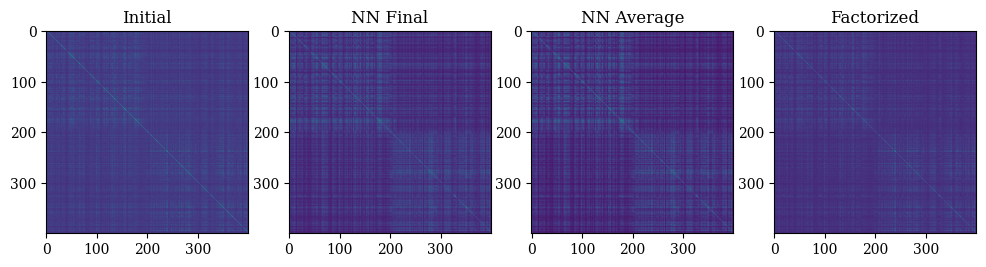

In [51]:
def reshape_K(K):
    return K.reshape(K.shape[0] * K.shape[1], K.shape[2] * K.shape[3])

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].imshow(reshape_K(K0))
axes[0].set_title("Initial")

axes[1].imshow(reshape_K(K_NN))
axes[1].set_title("NN Final")

axes[2].imshow(reshape_K(K_bar))
axes[2].set_title("NN Average")

axes[3].imshow(reshape_K(K_fac))
axes[3].set_title("Factorized")

plt.show()


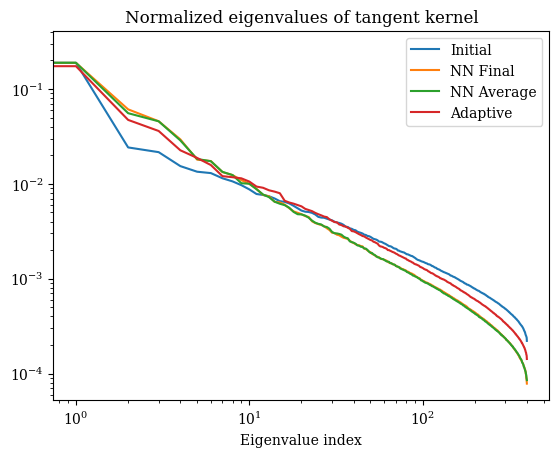

In [66]:
kernels = [K0, K_NN, K_bar, K_fac]
labels = ["Initial", "NN Final", "NN Average", "Adaptive"]

for K, label in zip(kernels, labels):
    d = jnp.linalg.eigvalsh(reshape_K(K))[::-1]
    plt.plot(d / d.sum(), label=label)

# plt.yscale("log")
plt.title("Normalized eigenvalues of tangent kernel")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Eigenvalue index")
plt.legend()

plt.show()

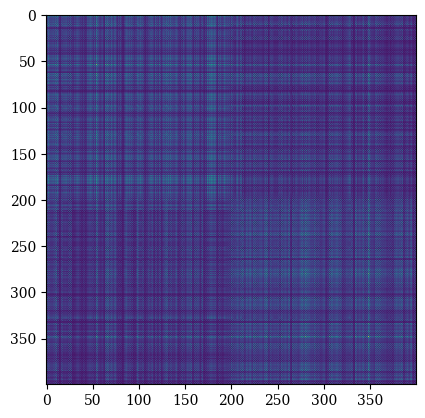

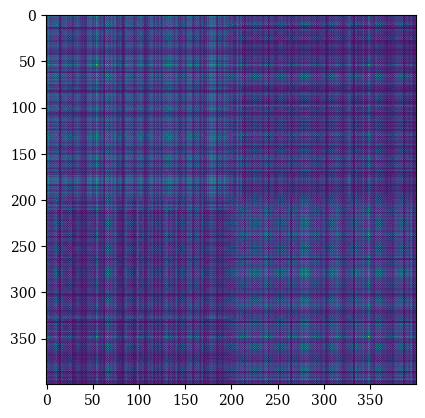

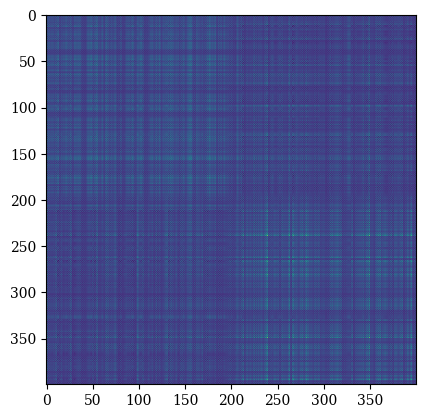

In [48]:
d, U = jnp.linalg.eigh(reshape_K(K_NN))
plt.imshow(U[:, -3:] @ jnp.diag(d[-3:]) @ U[:, -3:].T)
plt.show()

d, U = jnp.linalg.eigh(reshape_K(K_bar))
plt.imshow(U[:, -3:] @ jnp.diag(d[-3:]) @ U[:, -3:].T)
plt.show()

d, U = jnp.linalg.eigh(reshape_K(K_fac))
plt.imshow(U[:, -3:] @ jnp.diag(d[-3:]) @ U[:, -3:].T)
plt.show()

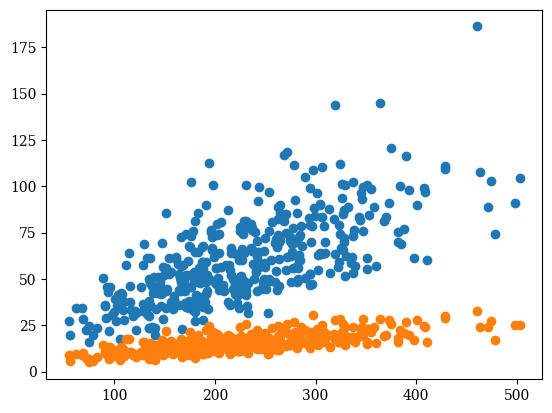

In [49]:
plt.scatter(jnp.diag(reshape_K(K_bar)), jnp.diag(reshape_K(K_fac)))
plt.scatter(jnp.diag(reshape_K(K_bar)), jnp.diag(reshape_K(K0)))

plt.show()